## Shared

### Notes

**SDSS vs BOSS** 
- Spectral Range: 3800-9200 Å vs 3650-10,400 Å
- Units: 10-17 erg cm-2 s-1 Å-1

In [1]:
from astropy.io import fits 
import pandas as pd
import matplotlib.pyplot as plt
#import smplotlib
import numpy as np
import torch 
from spender.data.sdss import BOSS
import os 

In [2]:
filename = '/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/data/sdss-qso-catalogue/spectra/7595/spec-7595-56957-0005.fits'

hdulist = fits.open(filename)
data = hdulist[1].data
loglam = data['loglam']
wave_raw = 10**loglam
flux = data['flux']
model_flux = data["model"]
ivar = data['ivar']
specinfo = hdulist[2].data[0]

## Vanilla Approach  

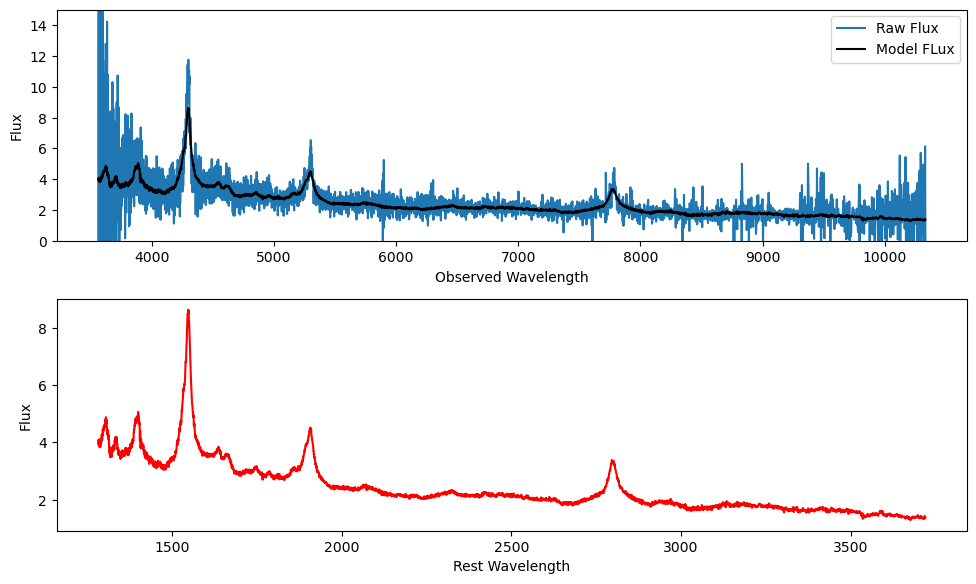

In [3]:
z = specinfo['Z']

fig, axs = plt.subplots(2, 1, figsize=(10,6))

axs[0].plot(wave_raw, flux, label='Raw Flux')
axs[0].plot(wave_raw, model_flux, label='Model FLux', color='black')

axs[1].plot(wave_raw/(1+z), model_flux, color='red')

axs[0].set(xlabel='Observed Wavelength', ylabel='Flux', ylim=(0,15))
axs[0].legend()

axs[1].set(xlabel='Rest Wavelength', ylabel='Flux')

fig.tight_layout()

### Spender Default

In [3]:
github = "pmelchior/spender"
sdss, model = torch.hub.load(github, 'sdss_II', map_location=torch.device('cpu'))

data_dir = '/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/data/sdss-qso-catalogue/spectra'

ids = [(7595, 56957, 5)]

spec, w, z, norm, zerr = BOSS.make_batch(data_dir, ids)

with torch.no_grad():
    s, spec_rest, spec_reco = model._forward(spec, instrument=BOSS(), z=z)

s, spec_rest, spec_reco = s.numpy()[0], spec_rest.numpy()[0], spec_reco.numpy()[0]

print(len(s), len(spec_rest), len(spec_reco))

6 7000 4686


Using cache found in /Users/yaroslav/.cache/torch/hub/pmelchior_spender_main


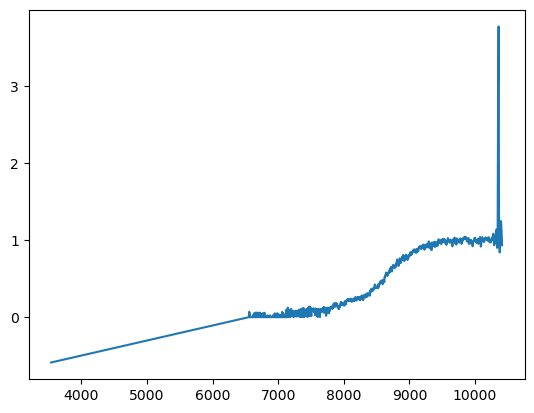

In [9]:
plt.plot(BOSS()._wave_obs, spec_reco)

In [7]:
# Where did 

sdss_wave_obs = 10 ** np.arange(3.578, 3.97, 0.0001) 
boss_wave_obs = 10 ** np.arange(3.549, 4.0175, 0.0001) 

for i in (sdss_wave_obs, boss_wave_obs):
    print(min(i), max(i), len(i))

3784.425847170932 9332.543007987684 3921
3539.9734108343464 10411.181076257095 4686


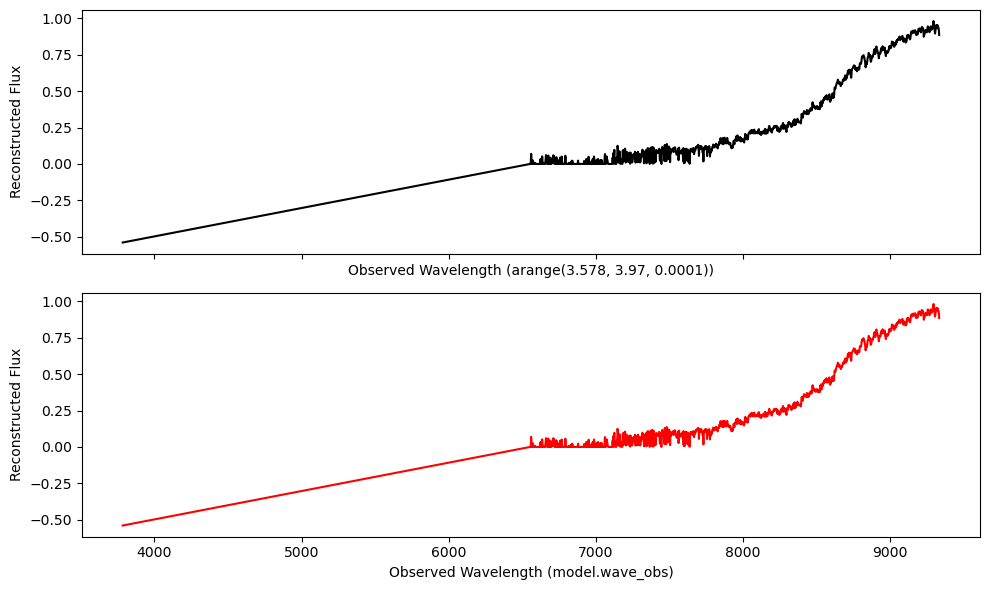

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(10,6), sharex=True)

#axs[0].plot(wave_raw, flux, label='Raw Flux')
#axs[0].plot(wave_raw, model_flux, label='Model FLux', color='black')

axs[0].plot(sdss_wave_obs, spec_reco, color='black')
axs[1].plot(model.wave_obs.numpy(), spec_reco, color='red')

axs[0].set(xlabel='Observed Wavelength (arange(3.578, 3.97, 0.0001))', ylabel='Reconstructed Flux')

axs[1].set(xlabel='Observed Wavelength (model.wave_obs)', ylabel='Reconstructed Flux')

fig.tight_layout()

# This shows there's a bug in the code that it's forcing the BOSS Spectra back to its original wavelength range. Also i'm so confused why spec_reco values are so small. 

### Spender Deconstructed

- So BOSS spectral range is wider than SDSS and has about 700 more observations total. Maybe I can interpolate BOSS initial spectrum into the SDSS range and then give it to SDSS? The biggest issue with doing this would be the Errors not being best to interpolate (look into how they are destributed/what their effect actually is, especially if we are using model flux)
- Is model flux even good to use as opposed to raw flux? It looks like they use model flux (maybe something to compare to?)
- Need to see if they do anything weird with z limits (because they were working on )
- Potential Issue: batch size in get_data_loader() being way too big for small initial dataset?
- Find .pkl files and kill them so you actually see changes on data processing method. 
- cool SDSS.get_image() method to use later. 
- Need to fix how we normalize the spectra (different species of objects)
- Issue could have arisen from me changing the last line in the function `return cls.prepare_spectrum(flocal)` to have `prepare_spectrum_()` instead. 
- Why do spec_reco and spec_rest have different lengths than anything else (3921 and 7000)? Where do these lengths come from? The first is the original length of the SDSS spectrum, so maybe that's where the issues come from? 
- There's a big issue because my quasar data gets shifted down 

- Here's a big takeaway: need to adjust the range that we normalize the data with because the one used for AGN is way too far out (5000 A), whereas after we adjust to restframe, our spectra often get cut off around 3500 A or sooner! From looking around on the internet, it looks like 2000-2500 is flat for our guys. So I'll test this next. 

In [36]:
## Deconstruction of prepare_spectrum() from SDSS.py 

filename = '/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/data/sdss-qso-catalogue/spectra/7595/spec-7595-56957-0005.fits'

hdulist = fits.open(filename)
data = hdulist[1].data
loglam = data['loglam']
flux = data['flux']
ivar = data['ivar']
specinfo = hdulist[2].data[0]

# apply bitmask, remove small values
mask = data["and_mask"].astype(bool) | (ivar <= 1e-6)
ivar[mask] = 0

# loglam is subset of _wave_obs, need to insert into extended tensor
L = len(BOSS._wave_obs)
start = int(np.around((loglam[0] - torch.log10(BOSS._wave_obs[0]).item())/0.0001))
if start<0:
    flux = flux[-start:]
    ivar = ivar[-start:]
    end = min(start+len(loglam), L)
    start = 0
else:
    end = min(start+len(loglam), L)

spec = torch.zeros(L)
w = torch.zeros(L)

# explicit type conversion to float32 to get to little endian
spec[start:end]  = torch.from_numpy(flux.astype(np.float32))
w[start:end] = torch.from_numpy(ivar.astype(np.float32))

# remove regions around skylines
w[BOSS._skyline_mask] = 0

# get redshift and error
z = torch.tensor(specinfo["Z"])
zerr = torch.tensor(specinfo["Z_ERR"])
extended_return = True

# normalize spectrum:
# for redshift invariant encoder: select norm window in restframe
wave_rest = BOSS._wave_obs / (1 + z)

# flatish region that is well observed out to z ~ 0.5
sel = (w > 0) & (wave_rest > 2000) & (wave_rest < 2500)
if sel.count_nonzero() == 0: norm = torch.tensor(0)
else: norm = torch.median(spec[sel])

# remove spectra (from training) for which no valid norm could be found
if not torch.isfinite(norm):
    norm = 0
else:
    spec /= norm
w *= norm**2

# spec, w, norm, z, zerr